<a href="https://colab.research.google.com/github/jungheejung/spacetop_biopac/blob/main/spacetop_biopac_analysis_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

# Physio analysis with Neurokit: Pipeline for spacetop data

### To navigate, simply click on a cell and hit Shift + Enter.

**The purpose of this notebook is to demonstrate:**
1.   how to load in biopac acquisition files into a python environment
2.   which set of neurokit functions to use
3.   a demonstration of an analysis (the effect of stimulus intensity on skin conductance response)



In [106]:
__author__ = "Heejung Jung, Isabel Neumann"
__copyright__ = "Spatial Topology Project"
__credits__ = [""] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung@colorado.edu"
__status__ = "Development"

If you encounter bugs, have any questions, or comments, please raise an issue in our GitHub repository: https://github.com/jungheejung/spacetop_biopac

### Import packages 


In [34]:
!pip install neurokit2
!pip install bioread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bioread: filename=bioread-3.0.0-py3-none-any.whl size=38443 sha256=ec7b425fb2fdcce62117726d551f2efb0c8aa1c6fe0a24cb1e046feeb8144b37
  Stored in directory: /root/.cache/pip/wheels/bf/7f/ff/41d3d449c3e476666556d14208b257b9fbd2650f9a25be6461
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=20388b2b3c1a67eb47a8a10b4b80246117c6e906c566645b83dc59881a2ba332
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built bioread docopt


In [23]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
from os.path import join
import itertools
from statistics import mean

plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

## Download example dataset (spacetop cue-expectancy task, sub-0051, ses-03, run-02)

In [28]:
!gdown 1SMnCANtc3LuocGTFq1d7ZrzlchWb_24v
!unzip /content/example_data.zip

Downloading...
From: https://drive.google.com/uc?id=1SMnCANtc3LuocGTFq1d7ZrzlchWb_24v
To: /content/example_data.zip
100% 62.6M/62.6M [00:00<00:00, 112MB/s]
Archive:  /content/example_data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/sub-0051/
  inflating: data/sub-0051/.DS_Store  
  inflating: __MACOSX/data/sub-0051/._.DS_Store  
   creating: data/sub-0051/ses-04/
   creating: data/sub-0051/ses-03/
   creating: data/sub-0051/ses-01/
  inflating: data/sub-0051/ses-04/.DS_Store  
  inflating: __MACOSX/data/sub-0051/ses-04/._.DS_Store  
   creating: data/sub-0051/ses-04/physio/
   creating: data/sub-0051/ses-04/beh/
  inflating: data/sub-0051/ses-03/.DS_Store  
  inflating: __MACOSX/data/sub-0051/ses-03/._.DS_Store  
   creating: data/sub-0051/ses-03/physio/
   creating: data/sub-0051/ses-03/beh/
  inflating: data/sub-0051/ses-01/.DS_Store  
  inflating: __MACOSX/data/sub-0051/ses-01/._.DS_Store  
   creating: data

## Load data

Feed in meta data for data files

In [31]:
pwd = os.getcwd()
# sub-0051_ses-03_run-02
main_dir = pwd
sub_num = 51; ses_num = 3; run_num = 2
sub = f"sub-{sub_num:04d}"; 
ses = f"ses-{ses_num:02d}"
run = f"run-{run_num-1:02d}"
physio_fname = join(main_dir, 'data', sub, ses, 'physio', f"SOCIAL_spacetop_{sub}_{ses}_task-social_ANISO.acq")
beh_fname = glob.glob(join(main_dir, 'data', sub, ses, 'beh', f"{sub}_{ses}_task-social_{run}-*_beh.csv"))[0]

In [35]:
print("load physio data...")
physio_df, spacetop_samplingrate = nk.read_acqknowledge(physio_fname)
print("check physio data columns: ",physio_df.columns)

beh_df = pd.read_csv(beh_fname)

load physio data...
check physio data columns:  Index(['Skin Conductance (EDA) - EDA100C-MRI', 'Pulse (PPG) - PPG100C',
       'fMRI Trigger - CBLCFMA - Current Feedba',
       'TSA2 TTL - CBLCFMA - Current Feedback M', 'trigger', 'fixation', 'cue',
       'expect', 'administer', 'actual', 'C15', 'C16'],
      dtype='object')


## Note about data structure






In spacetop, we collected all 6 runs in one acquisition file. In between runs, data collection stopped; we resumed again before MRtrigger. 

As you can see from the output above, we have a number of channels recorded in this physio file.

### Description of the channels

**A. Two Physio (analog) channels**
1.   Skin  Conductance (EDA)
2.   Pulse (PPG)

**B. Digital channels**<br> we toggled the channels whenever  MATlab-stim PC transitioned to a new event. In other words, we have boxcar signals for whenever an event was displayed on screen.

1.   **`trigger`**: when the experiment started/finished, i.e. one boxcar for duration of experiment
2.   **`fixation`**: when the fixation was present on screen
3.   **`cue`**: when the cue was present on screen (1s per trial, 2 levels of high vs. low)
4.   **`expect`**: when the participant saw the "expect" keyword until they rated their expectation ratings for the upcoming stimulus
5.   **`administer`**: when the participant undergoes the stimulus delivery (5s per trial; 9s for pain run, 5s plateau; 3 levels of high vs. med vs. low stimulus intensity)
6.   **`actual`**:  when the participant saw the "actual" keyword until they rated their actual ratings for the experienced stimulus

**C. TTL channels**

1.   **`fMRI Trigger - CBLCFMA - Current Feedba`**: TTl signals from the radio-frequency (RF) pulses, recorded in columns. In this study, we would have a TTL for every .46 sec.
2.   **`TSA2 TTL - CBLCFMA - Current Feedback M`**: Only for pain runs. We recorded the TTL signals for every pain stimulus. 1) initiation of pain stimulus 2) time it reached intended temperature (beginning of plateau), 3) time it terminated intended termperature (end of pleateau), and 4) return to baseline temperatuer of 32 degrees

In [1]:
physio_df.plot()

NameError: ignored

We'll first check if the dataframes look kosher. <br>
Question: Do we see 6 runs of data chunks?

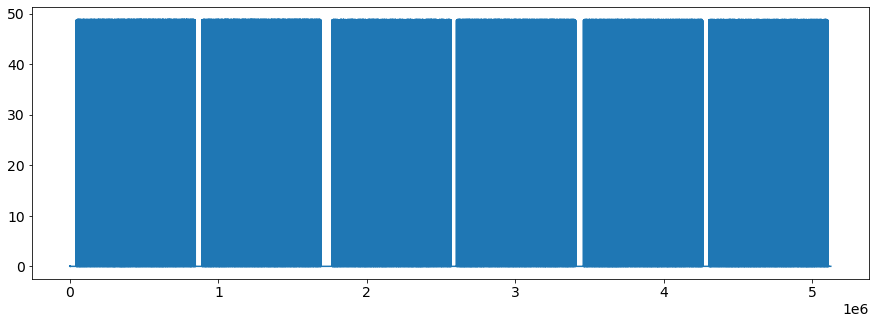

In [44]:
physio_df['fMRI Trigger - CBLCFMA - Current Feedba'].plot()

Question: Are the stimulus delivered nicely delivered for all 6 runs? (12 trials per run)

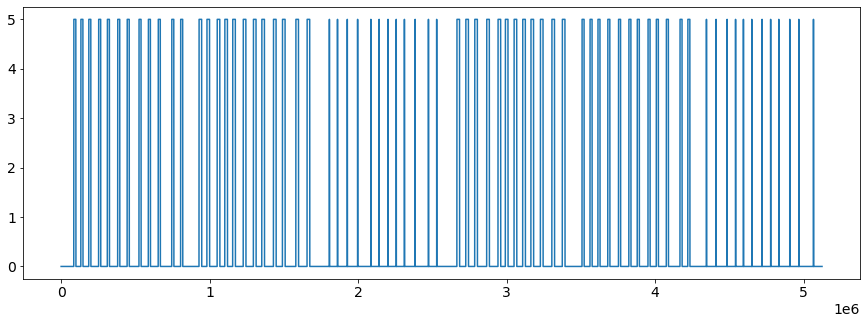

In [45]:
physio_df['administer'].plot()

Question: Do we see TSA2 TTLs for the pain runs?

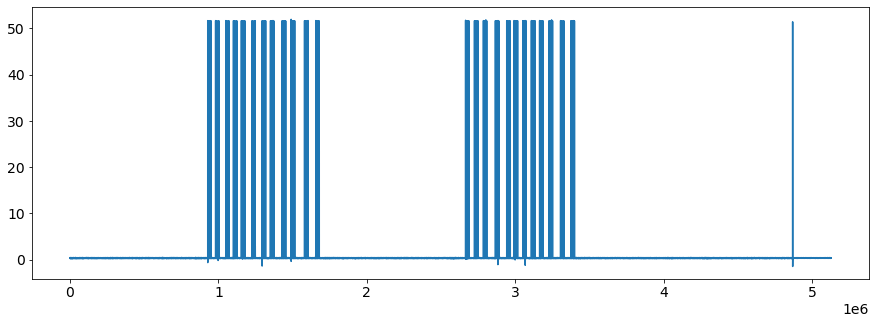

In [46]:
physio_df['TSA2 TTL - CBLCFMA - Current Feedback M'].plot()

## Extract 1 run

In [43]:
# Extract 1 run
mid_val = (np.max(physio_df['trigger']) - np.min(physio_df['trigger']))/2
physio_df.loc[physio_df['trigger'] > mid_val, 'fmri_trigger'] = 5
physio_df.loc[physio_df['trigger'] <= mid_val, 'fmri_trigger'] = 0

start_df = physio_df[physio_df['fmri_trigger'] > physio_df['fmri_trigger'].shift(1)].index
stop_df = physio_df[physio_df['fmri_trigger'] < physio_df['fmri_trigger'].shift(1)].index
print(f"* indices of each run's start point 'start_df': \n\t{start_df}")
print(f"* indices of each run's end point: 'stop_df': \n\t{stop_df}") 

# Organize data: transition
df_transition = pd.DataFrame({
                        'start_df': start_df, 
                        'stop_df': stop_df
                        })
run_subset = physio_df[df_transition.start_df[run_num-1]: df_transition.stop_df[run_num-1]]
run_df = run_subset.reset_index()
print("\n* extract dataframe based on run number")
run_df.head()

* indices of each run's start point 'start_df': 
	Int64Index([43850, 890568, 1765932, 2603584, 3458812, 4302610], dtype='int64')
* indices of each run's end point: 'stop_df': 
	Int64Index([841528, 1688195, 2563573, 3401638, 4256488, 5100278], dtype='int64')

* extract dataframe based on run number


,index,Skin Conductance (EDA) - EDA100C-MRI,Pulse (PPG) - PPG100C,fMRI Trigger - CBLCFMA - Current Feedba,TSA2 TTL - CBLCFMA - Current Feedback M,trigger,fixation,cue,expect,administer,actual,C15,C16,fmri_trigger
0,890568,9.777831,-0.016174,0.009155,0.308228,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,890569,9.774779,-0.016174,0.009155,0.317383,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,890570,9.779357,-0.017090,0.009155,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,890571,9.777831,-0.017090,0.003052,0.372314,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,890572,9.776305,-0.016479,0.012207,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


Now plot dataframe to check if we've isolated one run

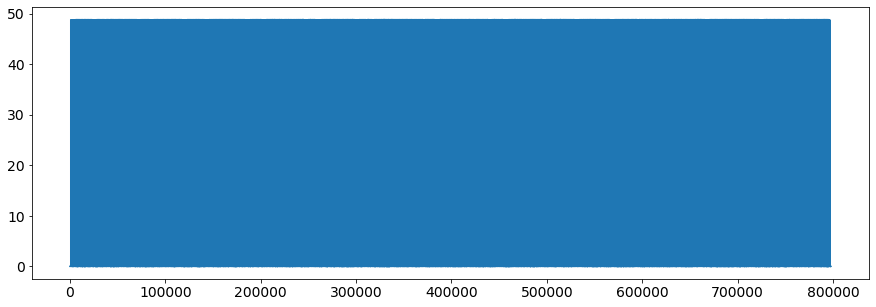

In [47]:
run_df['fMRI Trigger - CBLCFMA - Current Feedba'].plot()

In [52]:
print(f"Check run length (s): {run_df.shape[0]/spacetop_samplingrate}")

Check run length (s): 398.8135


Check TTL within run


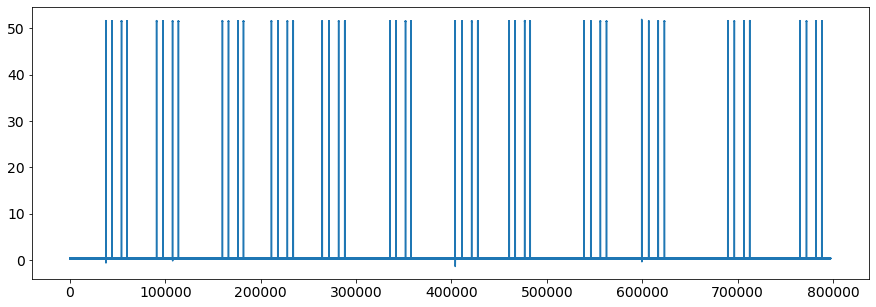

In [53]:
print(f"Check TTL within run")
run_df['TSA2 TTL - CBLCFMA - Current Feedback M'].plot()

## Baseline correction

#### Significance of baseline correction<br>
Baseline correction is important when using interval related analyses. For instance, we might want to compare the average signal difference between a pain run vs. a cognitive run. This is when we would use interval-related analayses. The signals extend for a longer time period, which makes baseline correction imperative. Only after correct baseline correction can we check the overall signal difference. 

#### Methods of baseline correction:
1.   subtract mean baseline, using the 6 TRs
2.   using the fixation period from tthe entire run
3.   using the fixation period from corresponding trial


In this notebook, we'll use method 2, which collapses all of the fixation periods into one bin. We average these signals and subtract it from the main EDA signal. 

In [ ]:
fix_bool = run_df['fixation'].astype(bool).sum()
print(f"confirming the number of fixation non-szero timepoints: {fix_bool}")
print(f"this amounts to {fix_bool/spacetop_samplingrate} seconds")

baseline using the 6 TR: 9.62573771505028
baseline using fixation from entire run: 8.379528779141685


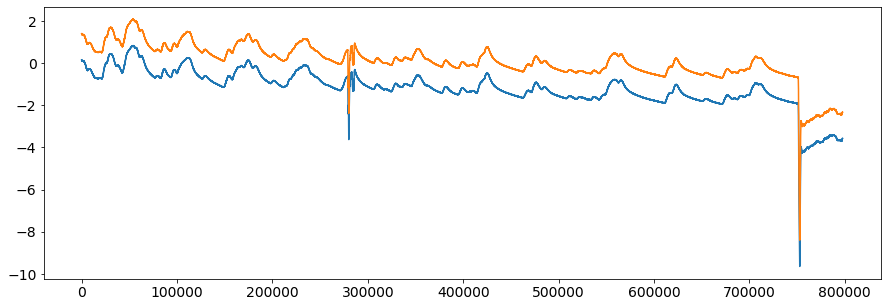

In [54]:
# baseline correction method 1: use the first 6 dummy scan period
baseline_method01 = run_df['Skin Conductance (EDA) - EDA100C-MRI'].loc[0:5520].mean()
run_df['EDA_corrected_01tr'] = run_df['Skin Conductance (EDA) - EDA100C-MRI'] - baseline_method01

# baseline correction method 02: use the fixation period from the entire run
mask = run_df['fixation'].astype(bool)
baseline_method02 = run_df['Skin Conductance (EDA) - EDA100C-MRI'].loc[mask].mean()
run_df['EDA_corrected_02fixation'] = run_df['Skin Conductance (EDA) - EDA100C-MRI'] - baseline_method02

# TODO method 03: per trial, grab the baseline fixation average signal

print(f"baseline using the 6 TR: {baseline_method01}")
print(f"baseline using fixation from entire run: {baseline_method02}")
run_df['EDA_corrected_01tr'].plot()
run_df['EDA_corrected_02fixation'].plot()
# TODO: add legend, which color is which?

## Neurokit event extraction

### 01 extract events based on **cue**

In [55]:
mid_val = (np.max(run_df['cue']) - np.min(run_df['cue']))/2
run_df.loc[run_df['cue'] > mid_val, 'cue'] = 5
run_df.loc[run_df['cue'] <= mid_val, 'cue'] = 0

start_cue = run_df[run_df['cue'] > run_df[ 'cue'].shift(1)]
stop_cue = run_df[run_df['cue'] < run_df[ 'cue'].shift(1)]
print(f"* indices of cue events' start point 'start_cue': \n\t{start_cue.index}")
print(f"* indices of cue events' end point: 'stop_cue': \n\t{stop_cue.index}")

cue_freq = len(start_cue)
print(f"* total number of trials: {cue_freq}")

* indices of cue events' start point 'start_cue': 
	Int64Index([ 15790,  75179, 133368, 190990, 251795, 303964, 374960, 446785,
            518578, 583368, 657363, 739160],
           dtype='int64')
* indices of cue events' end point: 'stop_cue': 
	Int64Index([ 17746,  77146, 135346, 192946, 253746, 305945, 376945, 448745,
            520545, 585345, 659345, 741145],
           dtype='int64')
* total number of trials: 12


### 02 extract events based on **expectation rating**

In [56]:
mid_val = (np.max(run_df['expect']) - np.min(run_df['expect']))/2
run_df.loc[run_df['expect'] > mid_val, 'expect_rating'] = 5
run_df.loc[run_df['expect'] <= mid_val, 'expect_rating'] = 0

start_expectrating = run_df[run_df['expect_rating'] > run_df[ 'expect_rating'].shift(1)]
stop_expectrating = run_df[run_df['expect_rating'] < run_df[ 'expect_rating'].shift(1)]
print(f"* indices of expect-rating events' start point 'start_expectrating': \n\t{start_expectrating.index}")
print(f"* indices of expect-rating events' end point: 'stop_expectrating': \n\t{stop_expectrating.index}")

expectrating_freq = len(start_expectrating)
print(f"* total number of trials: {expectrating_freq}")

* indices of expect-rating events' start point 'start_expectrating': 
	Int64Index([ 20225,  79992, 137793, 197991, 255192, 310991, 379392, 451192,
            525592, 588192, 662192, 743194],
           dtype='int64')
* indices of expect-rating events' end point: 'stop_expectrating': 
	Int64Index([ 23259,  82859, 141436, 200559, 257359, 316601, 382359, 453726,
            529326, 594538, 665198, 748796],
           dtype='int64')
* total number of trials: 12


### 03 extract events based on **stimulus delivery**

In [57]:
mid_val = (np.max(run_df['administer']) - np.min(run_df['administer']))/2
run_df.loc[run_df['administer'] > mid_val, 'stimuli'] = 5
run_df.loc[run_df['administer'] <= mid_val, 'stimuli'] = 0

start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
stop_stim = run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
print(f"* indices of stimulus events' start point 'start_stim': \n\t{start_stim.index}")
print(f"* indices of stimulus events' end point: 'stop_stim': \n\t{stop_stim.index}")

run_df[run_df[ 'stimuli'].diff() != 0].index
stim_freq = len(start_stim)
print(f"* total number of trials: {stim_freq}")

* indices of stimulus events' start point 'start_stim': 
	Int64Index([ 37732,  90817, 159839, 211206, 264438, 335437, 403801, 460417,
            538830, 599433, 689621, 765262],
           dtype='int64')
* indices of stimulus events' end point: 'stop_stim': 
	Int64Index([ 55546, 108746, 177746, 229146, 282347, 353345, 421745, 478345,
            556745, 617345, 707545, 783145],
           dtype='int64')
* total number of trials: 12


### 04 extract events based on **actual rating**

In [58]:
mid_val = (np.max(run_df['actual']) - np.min(run_df['actual']))/2
run_df.loc[run_df['actual'] > mid_val, 'actual_rating'] = 5
run_df.loc[run_df['actual'] <= mid_val, 'actual_rating'] = 0

start_actualrating = run_df[run_df['actual_rating'] > run_df[ 'actual_rating'].shift(1)]
stop_actualrating = run_df[run_df['actual_rating'] < run_df[ 'actual_rating'].shift(1)]
print(f"* indices of actual-rating events' start point 'start_actualrating': \n\t{start_actualrating.index}")
print(f"* indices of actual-rating events' end point: 'stop_actualrating': \n\t{stop_actualrating.index}")

actualrating_freq = len(start_actualrating)
print(f"* total number of trials: {actualrating_freq}")

* indices of actual-rating events' start point 'start_actualrating': 
	Int64Index([ 65992, 114992, 180792, 241592, 294792, 363825, 434394, 490992,
            562992, 620392, 719592, 789593],
           dtype='int64')
* indices of actual-rating events' end point: 'stop_actualrating': 
	Int64Index([ 70359, 117493, 183526, 244774, 298302, 369992, 438092, 495301,
            566161, 628392, 723026, 795193],
           dtype='int64')
* total number of trials: 12


In [134]:
test_string = 'sub-0059_ses-03_task-social_run-01-vicarious_beh'

In [138]:
([match for match in test_string.split('_') if "run" in match][0]).split('-')[2]

'vicarious'

### 05 extract TTLs based on **TTL column** and event boundaries

**We need to use a slightly different method. Here's the problem space:**<br>
* There are 4 TTLs for each trial. 
* The problem is, sometimes, TSA2 fails. There could be 3, there could be 1 TTL per trial in the case of this failure. Therefore... extracting TTLs becomes difficult, because we need to identify which TTL belongs to which trial. 

**Solution:**<br>
One way to deal with this problem is to set event boundaries. 
* We know that the stimulus delivery period is sandwiched in between an expectation rating and an actual rating. 
* We'll use these time periods to figure out whether a TTL belongs to this trial vs. not. 
* We'll be using variables such as 'expect_start' and 'actual_end' as our event boundaries.

##### 5.1 first build a dataframe to store the extracted TTLs

In [59]:
df_onset = pd.DataFrame({
    'expect_start': start_expectrating.index, 
    'actual_end': stop_actualrating.index,
    'stim_start': np.nan,
    'stim_end':np.nan
})

df_stim = pd.DataFrame({
    'stim_start': start_stim.index, 
    'stim_end': stop_stim.index
    })

final_df = pd.DataFrame()

In [60]:
mid_val = (np.max(run_df['TSA2 TTL - CBLCFMA - Current Feedback M']) - np.min(run_df['TSA2 TTL - CBLCFMA - Current Feedback M']))/2
run_df.loc[run_df['TSA2 TTL - CBLCFMA - Current Feedback M'] > mid_val, 'TTL'] = 5
run_df.loc[run_df['TSA2 TTL - CBLCFMA - Current Feedback M'] <= mid_val, 'TTL'] = 0

##### 5.2 calculate TTL onsets

In [61]:
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets = list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")

ttl onsets: [37752.5, 44102.0, 54105.5, 59809.0, 90885.5, 97633.5, 107636.5, 113742.0, 159898.5, 166227.0, 176227.0, 181974.0, 211280.5, 217981.5, 227979.0, 234087.5, 264494.5, 271691.0, 281693.5, 288168.5, 335485.5, 341834.0, 351837.0, 357631.5, 403879.0, 411157.0, 421157.5, 427555.5, 460481.5, 466712.5, 476710.0, 482495.5, 538904.5, 546083.0, 556086.0, 562489.0, 599508.5, 606725.5, 616726.0, 623192.0, 689701.5, 696519.5, 706520.0, 712618.0, 765324.5, 772133.0, 782136.0, 788239.0], length of ttl onset is : 48


In [62]:
for i in range(len(df_stim)):
    idx = pd.IntervalIndex.from_arrays(
        df_onset['expect_start'], df_onset['actual_end'])
    start_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_start')]
    interval_idx = df_onset[idx.contains(start_val)].index[0]
    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_start')] = start_val

    end_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_end')]
    interval_idx = df_onset[idx.contains(end_val)].index[0]
    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_end')] = end_val
    print(f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}")

# calculate TTL onsets
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")

# define empty TTL data frame 
df_ttl = pd.DataFrame(np.nan, 
                    index=np.arange(len(df_onset)),
                    columns= ['ttl_1', 'ttl_2','ttl_3', 'ttl_4'])

# identify which set of TTLs fall between expect and actual 
pad = 1 # seconds. you may increase the value to have a bigger event search interval
df_onset['expect_start_interval'] = df_onset['expect_start']-pad
df_onset['actual_end_interval'] = df_onset['actual_end']+pad
idx = pd.IntervalIndex.from_arrays(
            df_onset['expect_start_interval'], df_onset['actual_end_interval'])

for i in range(len(ttl_onsets)):
    
    val = ttl_onsets[i]
    print(f"{i}-th value: {val}")
    empty_cols = []
    interval_idx = df_onset[idx.contains(val)].index[0]
    print(f"\t\t* interval index: {interval_idx}")
    mask = df_ttl.loc[[interval_idx]].isnull()
    empty_cols = list(itertools.compress(np.array(df_ttl.columns.to_list()), mask.values[0]))
    print(f"\t\t* empty columns: {empty_cols}")
    df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val
    print(f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row")

# merge :: merge df_onset and df_ttl -> final output: final df 
final_df = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)
final_df['ttl_r1'] = final_df['ttl_1'] - final_df['stim_start']
final_df['ttl_r2'] = final_df['ttl_2'] - final_df['stim_start']
final_df['ttl_r3'] = final_df['ttl_3'] - final_df['stim_start']
final_df['ttl_r4'] = final_df['ttl_4'] - final_df['stim_start']

this is the 0-th iteration. stim value is 37732, and is in between index 0
this is the 1-th iteration. stim value is 90817, and is in between index 1
this is the 2-th iteration. stim value is 159839, and is in between index 2
this is the 3-th iteration. stim value is 211206, and is in between index 3
this is the 4-th iteration. stim value is 264438, and is in between index 4
this is the 5-th iteration. stim value is 335437, and is in between index 5
this is the 6-th iteration. stim value is 403801, and is in between index 6
this is the 7-th iteration. stim value is 460417, and is in between index 7
this is the 8-th iteration. stim value is 538830, and is in between index 8
this is the 9-th iteration. stim value is 599433, and is in between index 9
this is the 10-th iteration. stim value is 689621, and is in between index 10
this is the 11-th iteration. stim value is 765262, and is in between index 11
ttl onsets: [37752.5, 44102.0, 54105.5, 59809.0, 90885.5, 97633.5, 107636.5, 113742.0,

##### 5.3 plot final output

In [63]:
final_df

,expect_start,actual_end,stim_start,stim_end,expect_start_interval,actual_end_interval,ttl_1,ttl_2,ttl_3,ttl_4,ttl_r1,ttl_r2,ttl_r3,ttl_r4
0,20225,70359,37732.0,55546.0,20224,70360,37752.5,44102.0,54105.5,59809.0,20.5,6370.0,16373.5,22077.0
1,79992,117493,90817.0,108746.0,79991,117494,90885.5,97633.5,107636.5,113742.0,68.5,6816.5,16819.5,22925.0
2,137793,183526,159839.0,177746.0,137792,183527,159898.5,166227.0,176227.0,181974.0,59.5,6388.0,16388.0,22135.0
3,197991,244774,211206.0,229146.0,197990,244775,211280.5,217981.5,227979.0,234087.5,74.5,6775.5,16773.0,22881.5
4,255192,298302,264438.0,282347.0,255191,298303,264494.5,271691.0,281693.5,288168.5,56.5,7253.0,17255.5,23730.5
5,310991,369992,335437.0,353345.0,310990,369993,335485.5,341834.0,351837.0,357631.5,48.5,6397.0,16400.0,22194.5
6,379392,438092,403801.0,421745.0,379391,438093,403879.0,411157.0,421157.5,427555.5,78.0,7356.0,17356.5,23754.5
7,451192,495301,460417.0,478345.0,451191,495302,460481.5,466712.5,476710.0,482495.5,64.5,6295.5,16293.0,22078.5
8,525592,566161,538830.0,556745.0,525591,566162,538904.5,546083.0,556086.0,562489.0,74.5,7253.0,17256.0,23659.0
9,588192,628392,599433.0,617345.0,588191,628393,599508.5,606725.5,616726.0,623192.0,75.5,7292.5,17293.0,23759.0


In [72]:
ttl2 = final_df['ttl_2'].values.tolist()
plateau_start = np.ceil(ttl2).astype(int)
plateau_start

array([ 44102,  97634, 166227, 217982, 271691, 341834, 411157, 466713,
       546083, 606726, 696520, 772133])

In [79]:
event_stim = {'onset':np.array(start_stim.index),
'duration':np.repeat(spacetop_samplingrate*5, 12),
'label':np.array(np.arange(12), dtype='<U21'),
'condition':beh_df['param_stimulus_type'].values.tolist()}

In [80]:
event_stim

{'onset': array([ 37732,  90817, 159839, 211206, 264438, 335437, 403801, 460417,
        538830, 599433, 689621, 765262]),
 'duration': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.]),
 'label': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
       dtype='<U21'),
 'condition': ['med_stim',
  'high_stim',
  'high_stim',
  'low_stim',
  'med_stim',
  'low_stim',
  'med_stim',
  'med_stim',
  'high_stim',
  'low_stim',
  'low_stim',
  'high_stim']}

### Manage events: based on plateau of pain stimulus (TTL)

### Check alignment with physio data and TTL signal

In [70]:
run_physio = run_df[['EDA_corrected_02fixation',
                    'Pulse (PPG) - PPG100C',
                    'TTL']]
run_physio

,EDA_corrected_02fixation,Pulse (PPG) - PPG100C,TTL
0,1.398302,-0.016174,0.0
1,1.395250,-0.016174,0.0
2,1.399828,-0.017090,0.0
3,1.398302,-0.017090,0.0
4,1.396776,-0.016479,0.0
...,...,...,...
797622,-2.314161,-0.009155,0.0
797623,-2.312635,-0.009766,0.0
797624,-2.312635,-0.010071,0.0
797625,-2.314161,-0.010681,0.0


/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


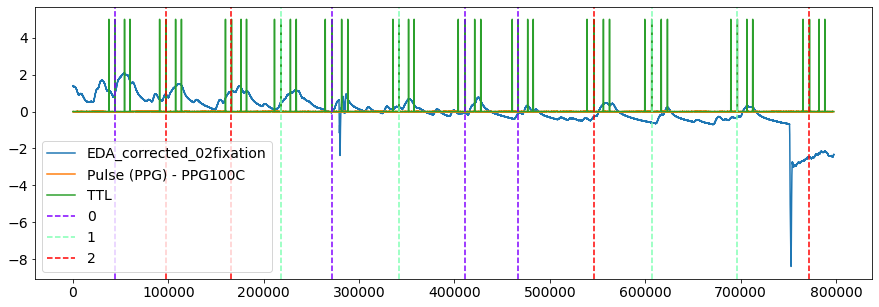

In [71]:
ttl2 = final_df['ttl_2'].values.tolist()
plateau_start = np.ceil(ttl2).astype(int)
event_plateau = {'onset':np.array(plateau_start),
'duration':np.repeat(spacetop_samplingrate*5, 12),
'label':np.array(np.arange(12)),
'condition':beh_df['param_stimulus_type'].values.tolist()}

plot = nk.events_plot(event_plateau, run_physio)

### prepare behavioral data to merge with physio data

In [64]:
beh_df['cond_name'] = beh_df['param_cue_type'].astype(str) + '_' + beh_df['param_stimulus_type'].astype(str)

## Process EDA signal

note:

* all these steps are included in nk.eda_process and also in nk.bio_process
* with subdiving into low-level functions, we have more control over parameters like:
    * filters
    * minimum amplitude for SCRs (related to specific stimulus, not non-specific SCRs which appear in every eda signal but are not particularly related to a stimulus)


### processing steps include:

1. sanitize signal
  * returns a default indexed signal (really necessary?)
  
2. filter signal (comparable to nk.eda_clean)
  * returns array with filtered signal
  * smoothing or low-pass filtering (e.g., Butterworth filter) recommended to remove high-frequency noise and small artifacts
3. decompose signal into phasic & tonic component
  * suggested by neurokit documentation -> helps to provide a more accurate estimation of the true SCR amplitude
  * signal is furthermore standardized which is also suggested by neurokit documentation -> useful in presence of high inter-individual variations, which usually is the case for pain perception
  * EDA_Tonic channel represents the skin conductance level (another measure of tonic skin conductance activity)
4. find peaks
  * returns dict with amplitude of SCR, samples at which SCR onset and SCR peaks occur (accessible with "SCR_Amplitude", "SCR_Onsets", "SCR_Peaks")
5. store signal

-- input from Isabel Neumann [isabel.neumann@dartmouth.edu](isabel.neumann@dartmouth.edu)

### 01, 02 EDA sanitize & filter signals

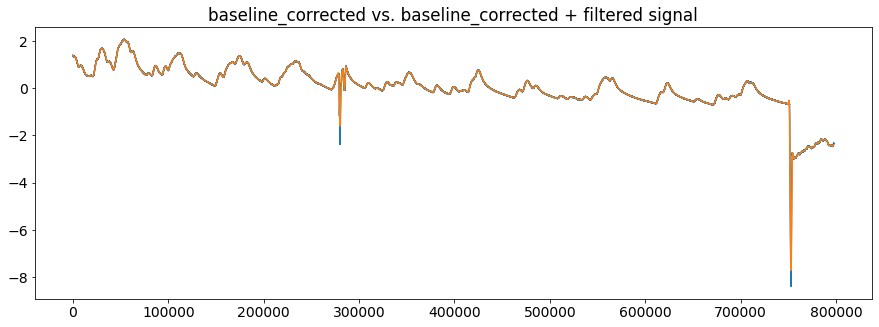

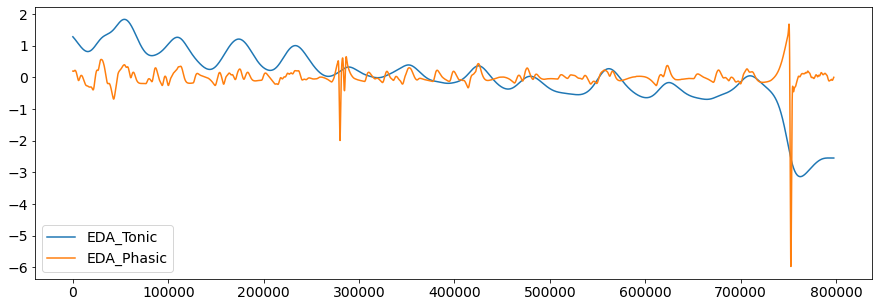

In [75]:

# IF you want to use raw signal
# eda_signal = nk.signal_sanitize(run_physio["Skin Conductance (EDA) - EDA100C-MRI"])
# eda_raw_plot = plt.plot(run_df["Skin Conductance (EDA) - EDA100C-MRI"])

# USE baseline corrected signal
eda_signal = nk.signal_sanitize(run_physio["EDA_corrected_02fixation"])
eda_filters = nk.signal_filter(eda_signal, 
                               sampling_rate=spacetop_samplingrate, 
                               highcut=1, method="butterworth", order=2)

eda_raw_plot = plt.plot(run_df["EDA_corrected_02fixation"])
eda_filters_plot = plt.plot(eda_filters)
plt.title('baseline_corrected vs. baseline_corrected + filtered signal')
plt.show()

### 03 decompose EDA signal (tonic/phasic)

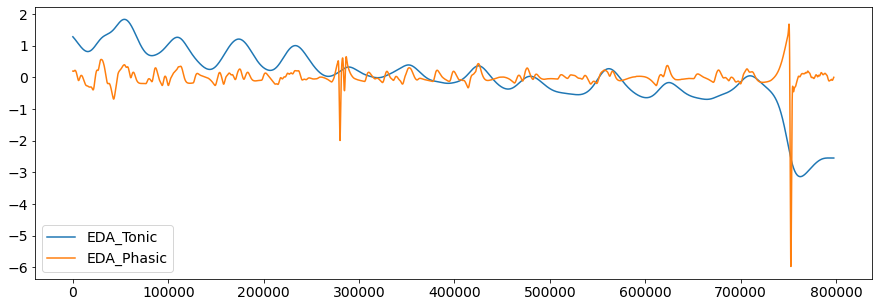

In [76]:

eda_decomposed = nk.eda_phasic(nk.standardize(eda_filters), 
                               sampling_rate=spacetop_samplingrate) 
eda_decomposed_plot = eda_decomposed.plot()

eda_peaks, info = nk.eda_peaks(eda_decomposed["EDA_Phasic"].values,
                               sampling_rate=spacetop_samplingrate, 
                               method = "neurokit", amplitude_min = 0.02)  
info["sampling_rate"] = spacetop_samplingrate

signals = pd.DataFrame({"EDA_Raw": eda_signal, "EDA_Clean": eda_filters})
eda_processed = pd.concat([signals, eda_decomposed, eda_peaks], axis=1) 
eda_level_signal = eda_processed["EDA_Tonic"] # for skin conductance level

### * Interim: `eda_epoch` Define epochs for EDA signal
* eda_epochs: snipping out segments based on start of heat pain stimulus (plateau?) with eda_processed
* eda_epochs_BL: eda_epochs but with baseline correction (necessary?)
* eda_epochs_level: snipping out segments based on plateau of heat pain stimulus with tonic channel of eda_processed for skin conductance level
* eda_epochs_physioBL: snipping out segments based on trigger column (beginning of experiment) for extraction of physio baseline correction

In [118]:
eda_epochs_BL = nk.epochs_create(eda_processed, 
                                 event_plateau, 
                                 sampling_rate=spacetop_samplingrate, 
                                 epochs_start=0, 
                                 epochs_end=9,
                                 baseline_correction=True)
eda_epochs_BL[0]

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime,Index,Label,Condition
0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,med_stim
0.0005,-0.001526,0.000205,0.000037,0.000189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,med_stim
0.0010,0.000000,0.000411,0.000074,0.000379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,med_stim
0.0015,0.004578,0.000617,0.000110,0.000568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,med_stim
0.0020,0.001526,0.000822,0.000147,0.000757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,med_stim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.9980,0.585938,0.585666,0.023214,0.621100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17995.0,0,med_stim
8.9985,0.584412,0.585702,0.023157,0.621196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17996.0,0,med_stim
8.9990,0.582886,0.585738,0.023101,0.621292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17997.0,0,med_stim
8.9995,0.585938,0.585774,0.023044,0.621388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17998.0,0,med_stim


Output of the epochs is a dictionary [ TODO: insert neurokit link ] 
We'll check out one effect. 

In [119]:
eda_epochs['0']

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime,Index,Label,Condition
0.0000,1.134325,1.133110,1.386487,-0.191113,0,0,0.0,0.0,0.0,0,0.0,37732,0,med_stim
0.0005,1.135851,1.133128,1.386504,-0.191111,0,0,0.0,0.0,0.0,0,0.0,37733,0,med_stim
0.0010,1.135851,1.133146,1.386521,-0.191108,0,0,0.0,0.0,0.0,0,0.0,37734,0,med_stim
0.0015,1.131273,1.133164,1.386539,-0.191106,0,0,0.0,0.0,0.0,0,0.0,37735,0,med_stim
0.0020,1.135851,1.133181,1.386556,-0.191104,0,0,0.0,0.0,0.0,0,0.0,37736,0,med_stim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.9980,1.988817,1.993089,1.818114,0.323356,0,0,0.0,0.0,0.0,0,0.0,55727,0,med_stim
8.9985,1.985765,1.993045,1.818100,0.323321,0,0,0.0,0.0,0.0,0,0.0,55728,0,med_stim
8.9990,1.988817,1.993000,1.818086,0.323286,0,0,0.0,0.0,0.0,0,0.0,55729,0,med_stim
8.9995,1.993395,1.992956,1.818072,0.323251,0,0,0.0,0.0,0.0,0,0.0,55730,0,med_stim


In [120]:
eda_epochs_level = nk.epochs_create(eda_level_signal, 
                                    event_plateau, 
                                    sampling_rate=spacetop_samplingrate, 
                                    epochs_start=-1, 
                                    epochs_end=8,
                                    baseline_correction=True)
eda_epochs_level[0]

eda_epochs_tonic_decomposed = nk.epochs_create(eda_level_signal, 
                              event_plateau, 
                              sampling_rate=spacetop_samplingrate, 
                              epochs_start=-1, 
                              epochs_end=8,
                              baseline_correction=True)
eda_epochs_tonic_decomposed[0]

,Signal,Index,Label,Condition
-1.0000,-0.032917,-999.5,0,med_stim
-0.9995,-0.032886,-998.5,0,med_stim
-0.9990,-0.032855,-997.5,0,med_stim
-0.9985,-0.032825,-996.5,0,med_stim
-0.9980,-0.032794,-995.5,0,med_stim
...,...,...,...,...
7.9980,0.161307,16995.5,0,med_stim
7.9985,0.161261,16996.5,0,med_stim
7.9990,0.161215,16997.5,0,med_stim
7.9995,0.161169,16998.5,0,med_stim


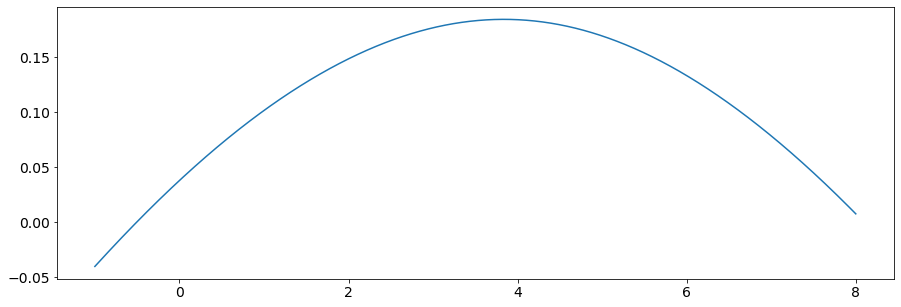

In [121]:
eda_epochs_level[2]["Signal"].plot()

### 04 Analyze EDA signal, i.e. find peaks

#### eda phasic

* event-related analysis
* of interest especially when analyzing EDA responses to specific stimuli
* returns:
   * EDA_SCR: Skin Conductance Response yes (1) or no (0) -> if yes, corresponding components are listed
   * EDA_Peak_Amplitude: maximum amplitude of phasic component of signal
   * SCR_Peak_Amplitude: peak amplitude of the first SCR in each epoch (parameter of interest if related to specific stimulus)
   * SCR_Peak_Amplitude_Time: timpepoint of each first SCR peak amplitude (peak should occur within 2-7 s after stimulus onset)
   * SCR_RiseTime: risetime of each first SCR (time it takes for SCR to reach peak amplitude from onset)
   * SCR_RecoveryTime: half-recovery time of each first SCR (time it takes for SCR to decrease to half amplitude)

#### eda tonic
* interval-related analysis
* of interest for longer time periods, also resting-state (input could therefore also be a whole condition instead of snipped-out epochs)
* returns:
   * SCR_Peaks_N: number of occurrences of Skin Conductance Response
   * SCR_Peaks_Amplitude_Mean: mean amplitude of SCR peak occurrences

#### eda level
* analysis of skin conductance level


In [122]:
eda_epochs['0']

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime,Index,Label,Condition
0.0000,1.134325,1.133110,1.386487,-0.191113,0,0,0.0,0.0,0.0,0,0.0,37732,0,med_stim
0.0005,1.135851,1.133128,1.386504,-0.191111,0,0,0.0,0.0,0.0,0,0.0,37733,0,med_stim
0.0010,1.135851,1.133146,1.386521,-0.191108,0,0,0.0,0.0,0.0,0,0.0,37734,0,med_stim
0.0015,1.131273,1.133164,1.386539,-0.191106,0,0,0.0,0.0,0.0,0,0.0,37735,0,med_stim
0.0020,1.135851,1.133181,1.386556,-0.191104,0,0,0.0,0.0,0.0,0,0.0,37736,0,med_stim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.9980,1.988817,1.993089,1.818114,0.323356,0,0,0.0,0.0,0.0,0,0.0,55727,0,med_stim
8.9985,1.985765,1.993045,1.818100,0.323321,0,0,0.0,0.0,0.0,0,0.0,55728,0,med_stim
8.9990,1.988817,1.993000,1.818086,0.323286,0,0,0.0,0.0,0.0,0,0.0,55729,0,med_stim
8.9995,1.993395,1.992956,1.818072,0.323251,0,0,0.0,0.0,0.0,0,0.0,55730,0,med_stim


In [123]:
eda_phasic = nk.eda_eventrelated(eda_epochs)
eda_phasic

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,med_stim,37732,0.396235,1,1.084711,8.110951,5.6005,NaN
1,1,high_stim,90817,0.237071,1,0.292987,2.950664,1.5440,7854.0
2,2,high_stim,159839,0.260698,1,0.349956,2.065615,2.9525,9560.0
3,3,low_stim,211206,0.139827,0,NaN,NaN,NaN,NaN
4,4,med_stim,264438,0.584637,1,0.668730,6.851381,3.5260,14335.0
5,5,low_stim,335437,0.300076,1,0.124626,1.694094,1.4240,5556.0
6,6,med_stim,403801,0.157723,0,NaN,NaN,NaN,NaN
7,7,med_stim,460417,0.293118,1,0.245370,3.571698,2.3590,9890.0
8,8,high_stim,538830,0.227121,0,NaN,NaN,NaN,NaN
9,9,low_stim,599433,0.084317,0,NaN,NaN,NaN,NaN


In [124]:
eda_phasic_BL = nk.eda_eventrelated(eda_epochs_BL)
eda_phasic_BL

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,med_stim,0.0,0.919256,1,1.084711,4.925774,5.6005,NaN
1,1,high_stim,0.0,0.349312,1,0.017929,7.671926,0.7220,1037.0
2,2,high_stim,0.0,0.182937,1,0.332048,4.353242,2.3455,3172.0
3,3,low_stim,0.0,0.222173,0,NaN,NaN,NaN,NaN
4,4,med_stim,0.0,0.789568,1,0.668730,3.224679,3.5260,7082.0
5,5,low_stim,0.0,0.369167,1,0.514909,5.350297,3.5090,15737.0
6,6,med_stim,0.0,0.569989,1,0.763892,6.950886,5.3605,NaN
7,7,med_stim,0.0,0.242812,1,0.245370,0.423524,2.3590,3594.0
8,8,high_stim,0.0,0.354781,1,0.424790,5.577810,4.0475,NaN
9,9,low_stim,0.0,0.484365,1,0.352462,8.238458,2.2195,NaN


/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


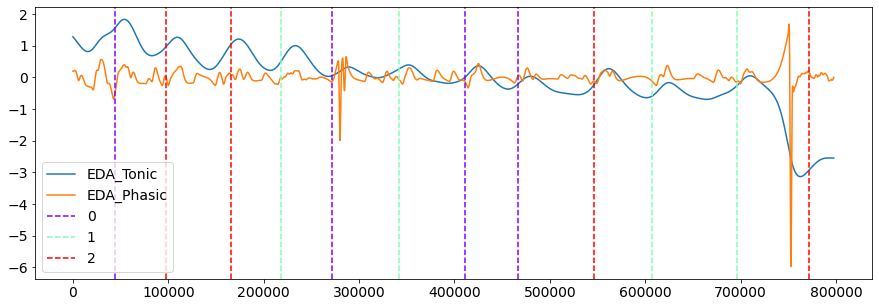

In [126]:
plot_eda_phasic = nk.events_plot(event_plateau, 
                                 eda_processed[["EDA_Tonic", "EDA_Phasic"]])

In [127]:
eda_tonic = nk.eda_intervalrelated(eda_epochs)
eda_tonic

,Label,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean
0,0,1,1.084711
1,1,1,0.292987
2,2,2,0.341002
3,3,0,NaN
4,4,1,0.668730
5,5,2,0.319767
6,6,0,NaN
7,7,2,0.327765
8,8,0,NaN
9,9,0,NaN


In [128]:
eda_tonic_BL = nk.eda_eventrelated(eda_epochs_BL)
eda_tonic_BL

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,med_stim,0.0,0.919256,1,1.084711,4.925774,5.6005,NaN
1,1,high_stim,0.0,0.349312,1,0.017929,7.671926,0.7220,1037.0
2,2,high_stim,0.0,0.182937,1,0.332048,4.353242,2.3455,3172.0
3,3,low_stim,0.0,0.222173,0,NaN,NaN,NaN,NaN
4,4,med_stim,0.0,0.789568,1,0.668730,3.224679,3.5260,7082.0
5,5,low_stim,0.0,0.369167,1,0.514909,5.350297,3.5090,15737.0
6,6,med_stim,0.0,0.569989,1,0.763892,6.950886,5.3605,NaN
7,7,med_stim,0.0,0.242812,1,0.245370,0.423524,2.3590,3594.0
8,8,high_stim,0.0,0.354781,1,0.424790,5.577810,4.0475,NaN
9,9,low_stim,0.0,0.484365,1,0.352462,8.238458,2.2195,NaN


In [129]:
# loop over dictionary
# calculate mean signal 
# make sure to include the label and condition
# eda_tonic_decomposed_df 
# etd_df

eda_level = pd.DataFrame(index = list(range(len(eda_epochs_level))),
                         columns=['trial_order', 'iv_stim', 'mean_signal'])
for ind in range(len(eda_epochs_level)):
    eda_level.iloc[ind, eda_level.columns.get_loc('mean_signal')] = eda_epochs_level[ind]["Signal"].mean()
    eda_level.iloc[ind, eda_level.columns.get_loc('trial_order')] = eda_epochs_level[ind]['Label'].unique()[0]
    eda_level.iloc[ind, eda_level.columns.get_loc('iv_stim')] = eda_epochs_level[ind]["Condition"].unique()[0]

eda_level

,trial_order,iv_stim,mean_signal
0,0,med_stim,0.199571
1,1,high_stim,0.214335
2,2,high_stim,0.114292
3,3,low_stim,0.328961
4,4,med_stim,0.128377
5,5,low_stim,0.093113
6,6,med_stim,0.225111
7,7,med_stim,0.172781
8,8,high_stim,0.320414
9,9,low_stim,0.205503


Note: eda_epochs_level uses the plateau onset 

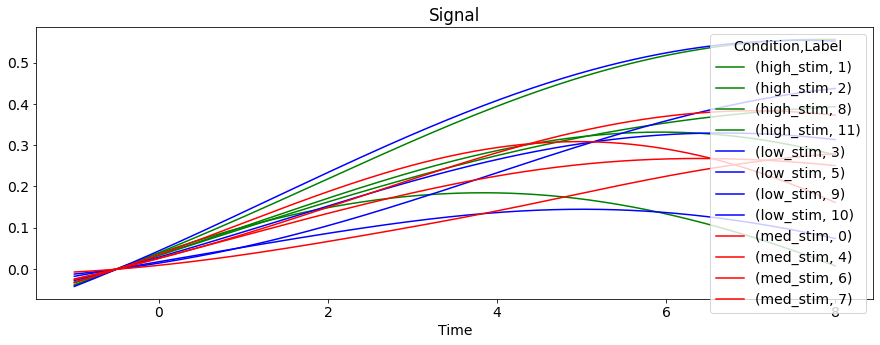

In [130]:
plot_level = nk.epochs_plot(eda_epochs_level)

In [133]:
eda_epochs_level[0].Signal

-1.0000   -0.032917
-0.9995   -0.032886
-0.9990   -0.032855
-0.9985   -0.032825
-0.9980   -0.032794
             ...   
 7.9980    0.161307
 7.9985    0.161261
 7.9990    0.161215
 7.9995    0.161169
 8.0000    0.161123
Name: Signal, Length: 18000, dtype: float64